## Demonstrating Eponential Smoothing Forecasting, - specifically the Holt-Winters Method.

Following this: https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/

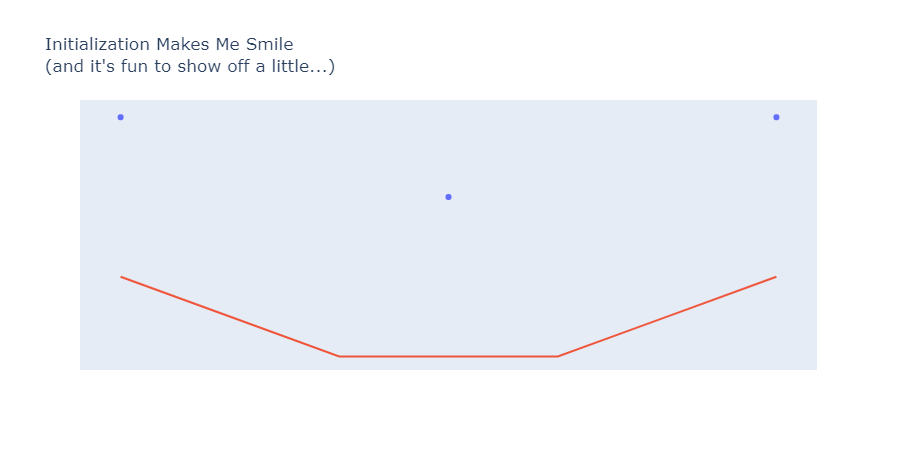

In [1]:
import ipdb
import math
import numpy as np
import pandas as pd
from scipy.optimize import minimize


import plotly.graph_objs as go
import chart_studio.plotly as ply
import plotly.tools as plytool
import plotly.figure_factory as ff
import plotly.offline as plyoff
import plotly.subplots as plysub

# plotly authentication - not needed for offline mode
#plytool.set_credentials_file(username='ahowe42', api_key='')

# if using jupyter lab, must have the plotly extension installed: https://github.com/jupyterlab/jupyter-renderers/tree/master/packages/plotly-extension
# jupyter labextension install @jupyterlab/plotly-extension
# to use plotly offline, need to initialize with a plot; might as well have fun with it
plyoff.init_notebook_mode(connected=True)
x1 = [1,4,7]; y1 = [7,5,7]
x2 = [1,2,3,4,5,6,7]; y2 = [3,2,1,1,1,2,3]
plyoff.iplot(go.Figure(data=[go.Scatter({'x':x1, 'y':y1, 'mode':'markers'}),
                             go.Scatter({'x':x2, 'y':y2, 'mode':'lines'})],
                                        layout=go.Layout(autosize=False,width=500,title="Initialization Makes Me Smile<br>(and it's fun to show off a little...)",
                                                         showlegend=False, xaxis={'showgrid':False, 'showticklabels':False},
                                                         yaxis={'showgrid':False, 'showticklabels':False})))

# if I want to show a df, I want to show *all* of it
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

### Define model metrics and the function for single, double, and triple exponential smoothing

In [2]:
# mean error
def ME(actl, pred):
    return np.mean(actl - pred)

# mean absolute error
def MAE(actl, pred):
    return np.mean(np.abs(actl - pred))

# median error
def MDE(actl, pred):
    return np.quantile(actl - pred, 0.5)

# median absolute error
def MDAE(actl, pred):
    return np.quantile(np.abs(actl - pred), 0.5)

# mean absolute percentage error
def MAPE(actl, pred):
    return 100*np.mean(np.abs(actl - pred)/pred)

# sum of squared errors
def SSE(actl, pred):
    return np.sum((actl - pred)**2)

# mean squared error
def MSE(actl, pred):
    return np.mean((actl - pred)**2)

In [3]:
def exponential_smoothing(data, alpha):
    '''
    Apply exponential smoothing to the levels
    '''
    smoothed = np.zeros(len(data)+1, dtype=float)
    smoothed[0] = data[0]
    for i, obs in enumerate(data[1:]):
        smoothed[i+1] = alpha*obs + (1-alpha)*smoothed[i]
    # forecast 1 step ahead
    smoothed[-1] = alpha*smoothed[-2] + (1-alpha)*smoothed[-3]
    return smoothed

In [4]:
def double_exponential_smoothing(data, alpha, beta, m):
    '''
    Apply exponential smoothing to the levels & trends
    '''
    n = len(data)
    # initialize
    smoothed = np.zeros(n+m, dtype=float)
    smoothed[0] = data[0]
    levels = np.zeros(n+m, dtype=float)
    trends = np.zeros(n+m, dtype=float)
    # iterate over datapoints
    for i in range(1, n+m):
        if i == 1:                 # initializing
            levels[i-1] = data[0]
            trends[i-1] = data[1] - data[0]
        if i >= n:                 # forecasting
            value = smoothed[i-1]
        else:                      # somewhere in the middle
            value = data[i]
        levels[i] = alpha*value + (1-alpha)*(levels[i-1]+trends[i-1])
        trends[i] = beta*(levels[i]-levels[i-1]) + (1-beta)*trends[i-1]
        smoothed[i] = levels[i-1]+trends[i]
    return levels, trends, smoothed

In [5]:
''' note the assumption that the data starts at the beginning of a "season"
and proceeds in exact integer counts of seasons '''
def trend_init(data, L):
    # compute the avg of trend averages for the first season
    return np.sum((data[(L):(2*L)] - data[:L])/L)/L

def season_init(data, L):
    # compute the average level per season
    rngStt = range(0, n, L)
    rngStp = range(L, n+1, L)
    avgs = [np.mean(data[stt:stp]) for stt, stp in zip(rngStt, rngStp)]
    return np.mean([data[stt:stp]-mn for stt, stp, mn in zip(rngStt, rngStp, avgs)], axis=0)

def triple_exponential_smoothing(data, alpha, beta, gamma, L, m):
    '''
    Apply exponential smoothing to the levels, trends, and seasons
    '''
    n = len(data)
    # initialize
    smoothed = np.zeros(n+m, dtype=float)
    smoothed[0] = data[0]
    levels = np.zeros(n+m, dtype=float)
    trends = np.zeros(n+m, dtype=float)
    seasons = np.zeros(n+m, dtype=float)    
    seasonLevs = season_init(data, L)
    # iterate over datapoints
    for i in range(1, n+m):
        thisSeasonLev = seasonLevs[i%L]
        if i == 1:                 # initializing
            levels[i-1] = data[0]
            trends[i-1] = trend_init(data, L)
        if i >= n:                 # forecasting
            levels[i] = levels[i-1]
            trends[i] = trends[i-1]
            seasons[i] = thisSeasonLev
            smoothed[i] = levels[i]+(i-n+1)*trends[i] + seasons[i]
        else:                      # somewhere in the middle
            value = data[i]
            levels[i] = alpha*(value - thisSeasonLev) + (1-alpha)*(levels[i-1]+trends[i-1])
            trends[i] = beta*(levels[i]-levels[i-1]) + (1-beta)*trends[i-1]
            seasons[i] = gamma*(value - levels[i]) + (1-gamma)*thisSeasonLev
            smoothed[i] = levels[i] + trends[i] + seasons[i]
            # update the season levels list
            seasonLevs[i%L] = seasons[i]
    return levels, trends, seasons, seasonLevs, smoothed

### Generate the data for modeling

72


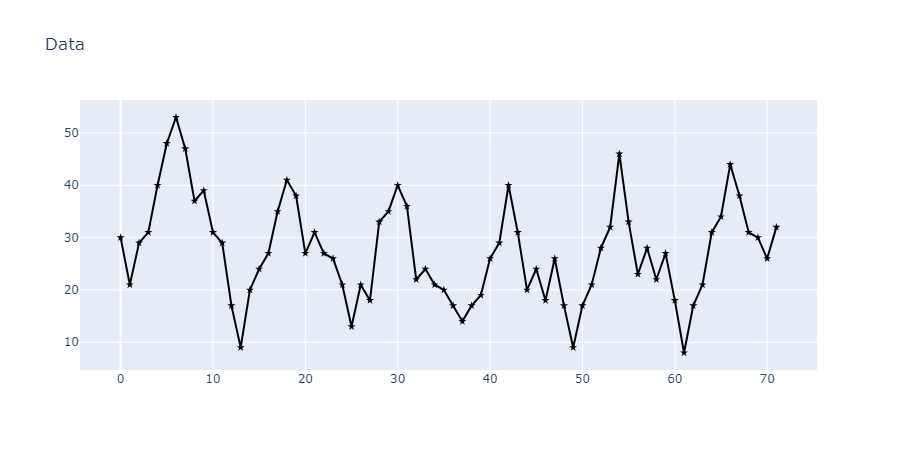

In [6]:
# prepare the data
data = np.asarray([30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,27,31,27,26,21,13,
                   21,18,33,35,40,36,22,24,21,20,17,14,17,19,26,29,40,31,20,24,18,26,17,9,17,21,
                   28,32,46,33,23,28,22,27,18,8,17,21,31,34,44,38,31,30,26,32])
n = len(data)
print(n)
# plot the data
fig = go.Figure(data=[go.Scatter(x=list(range(n)), y=data, mode='markers+lines',line={'color':'black'},
                                 marker={'color':'black', 'symbol':'star'})], layout=go.Layout({'title':'Data'}))
plyoff.iplot(fig)

### Optimally fit the single, double, and triple exponential smoothing to the data

In [7]:
# global optimization settings
meth = 'Nelder-Mead'
maxIter = 500
initCnt = 25
np.random.seed(42)

def MYOBJFUN(actl, pred):
    #res = ME(actl, pred)
    #res = MAE(actl, pred)
    #res = MDE(actl, pred)
    #res = MDAE(actl, pred)
    #res = MAPE(actl, pred)
    #res = SSE(actl, pred)
    res = MSE(actl, pred)
    return res

In [8]:
''' single exponential smoothing '''
# optimize alpha
minMe = lambda a: MYOBJFUN(data, exponential_smoothing(data, min(1, max(0, a)))[:-1])

# list of initial alphas to try
alphas = np.random.rand(initCnt)
optimS = [None]*initCnt
best = np.inf
bestOptimRes = None
for init in range(initCnt):
    # run the optimization
    optimRes = minimize(minMe, x0=alphas[init], method=meth, options={'maxiter':maxIter})
    # is it better than the current best?
    if optimRes.success & (optimRes.fun < best):
        bestOptimRes = optimRes
        best = optimRes.fun
        # talk
    print('%s, objective=%0.4f(%r), %d iterations; best=%0.4f'%\
          (optimRes.message, optimRes.fun, optimRes.x, optimRes.nit, best)) 
if bestOptimRes.success:
    alpha = min(1, max(0, bestOptimRes.x))
    print('Optimal value for alpha is %0.4f'%alpha)
else:
    alpha = 0.5
    print(bestOptimRes)
    
# execute
smoothed = exponential_smoothing(data, alpha)

# store results & compute error
single = pd.DataFrame(data, columns=['Data']).append(pd.Series(dtype=float), ignore_index=True)
single['ES_Sing'] = smoothed
single['ESErr_Sing'] = single['Data'] - single.ES_Sing
display(single.head())
print('Objective=%0.4f'%MYOBJFUN(data, smoothed[:-1]))

Optimization terminated successfully., objective=0.0000(array([1.2547094])), 18 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array([1.04578574])), 11 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array([1.13459061])), 15 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array([1.04765235])), 16 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array([1.14673701])), 20 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array([1.14655972])), 20 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array([1.17038479])), 21 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array([1.08272018])), 13 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array([1.05195127])), 16 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(

,Data,ES_Sing,ESErr_Sing
0,30.0,30.0,0.0
1,21.0,21.0,0.0
2,29.0,29.0,0.0
3,31.0,31.0,0.0
4,40.0,40.0,0.0


Objective=0.0000


In [9]:
''' double exponential smoothing'''
# optimize alpha & beta
minMe = lambda ab: MYOBJFUN(data, double_exponential_smoothing(data,
                                    min(1, max(0, ab[0])), min(1, max(0, ab[1])), m=0)[-1])

# list of initial alphas & betas to try
alphabetas = np.random.rand(initCnt, 2)
optimS = [None]*initCnt
best = np.inf
bestOptimRes = None
for init in range(initCnt):
    # run the optimization
    optimRes = minimize(minMe, x0=alphabetas[init], method=meth, options={'maxiter':maxIter})
    # is it better than the current best?
    if optimRes.success & (optimRes.fun < best):
        bestOptimRes = optimRes
        best = optimRes.fun
        # talk
    print('%s, objective=%0.4f(%r), %d iterations; best=%0.4f'%\
          (optimRes.message, optimRes.fun, optimRes.x, optimRes.nit, best))        
if bestOptimRes.success:
    alpha = min(1, max(0, bestOptimRes.x[0]))
    beta = min(1, max(0, bestOptimRes.x[1]))
    print('Optimal values: alpha=%0.4f, beta=%0.4f'%(alpha, beta))
else:
    alpha, beta = (0.5, 0.5)
    print(bestOptimRes)
    
# execute
forecasts = 2
l,t,s = double_exponential_smoothing(data, alpha, beta, forecasts)

# store results & compute error
double = pd.DataFrame(data, columns=['Data'])
for i in range(forecasts):
    double = double.append(pd.Series(dtype=float), ignore_index=True)
double['Level_Doub'] = l
double['Trend_Doub'] = t
double['ES_Doub'] = s
double['ESErr_Doub'] = double['Data'] - double.ES_Doub
display(double.head())
print('Objective=%0.4f'%MYOBJFUN(data, s[:-forecasts]))

Optimization terminated successfully., objective=0.0000(array([4.5238097 , 1.04146257])), 27 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array([1.5672098, 1.1066119])), 24 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array([2.07614321, 1.31439219])), 43 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array([13.77062336,  1.02160342])), 33 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array([1.02005195, 1.03805444])), 15 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array([3.50231835, 1.06912294])), 26 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array([1.29008493, 1.27870536])), 39 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array([14.14594881,  1.28309677])), 32 iterations; best=0.0000
Optimization terminated successfully., objective=0.0000(array(

,Data,Level_Doub,Trend_Doub,ES_Doub,ESErr_Doub
0,30.0,30.0,-9.0,30.0,0.0
1,21.0,21.0,-9.0,21.0,0.0
2,29.0,29.0,8.0,29.0,0.0
3,31.0,31.0,2.0,31.0,0.0
4,40.0,40.0,9.0,40.0,0.0


Objective=0.0000


In [10]:
''' triple exponential smoothing'''
L = 12 # season length
# optimize alpha, beta, and gamma
minMe = lambda abg: MYOBJFUN(data, triple_exponential_smoothing(data, 
                        min(1, max(0, abg[0])), min(1, max(0, abg[1])), min(1, max(0, abg[2])), L=L , m=0)[-1])

# list of initial alphas, betas, and gammas to try
alphabetagammas = np.random.rand(initCnt, 3)
optimS = [None]*initCnt
best = np.inf
bestOptimRes = None
for init in range(initCnt):
    # run the optimization
    optimRes = minimize(minMe, x0=alphabetagammas[init], method=meth, options={'maxiter':maxIter})
    # is it better than the current best?
    if optimRes.success & (optimRes.fun < best):
        bestOptimRes = optimRes
        best = optimRes.fun
        # talk
    print('%s, objective=%0.4f(%r), %d iterations; best=%0.4f'%\
          (optimRes.message, optimRes.fun, optimRes.x, optimRes.nit, best)) 
if bestOptimRes.success:
    alpha = min(1, max(0, bestOptimRes.x[0]))
    beta = min(1, max(0, bestOptimRes.x[1]))
    gamma = min(1, max(0, bestOptimRes.x[2]))
    print('Optimal values: alpha=%0.4f, beta=%0.4f, gamma=%0.4f'%(alpha, beta, gamma))
else:
    alpha, beta, gamma = (0.5, 0.5, 0.5)
    print(bestOptimRes)

# execute
#alpha = 0.716; beta = 0.029; gamma = 0.993 # values which supposedly are optimal, but increase the MSE/SSE
moreforecasts = 24
l,t,s,sl,p = triple_exponential_smoothing(data, alpha, beta, gamma, L, moreforecasts)

# store results & compute error
triple = pd.DataFrame(data, columns=['Data'])
for i in range(moreforecasts):
    triple = triple.append(pd.Series(dtype=float), ignore_index=True)
triple['Level_Trip'] = l
triple['Trend_Trip'] = t
triple['Seasn_Trip'] = s
triple['ES_Trip'] = p
triple['ESErr_Trip'] = triple['Data'] - triple.ES_Trip
display(triple.head())
print('Objective=%0.4f'%MYOBJFUN(data, p[:-moreforecasts]))

Optimization terminated successfully., objective=0.1040(array([0.96738295, 0.07130334, 0.07603036])), 50 iterations; best=0.1040
Optimization terminated successfully., objective=0.1039(array([ 9.69710478e-01,  7.13274188e-02, -6.10726137e-04])), 155 iterations; best=0.1039
Optimization terminated successfully., objective=0.1115(array([1.38700476, 0.06408549, 0.07506364])), 43 iterations; best=0.1039
Optimization terminated successfully., objective=0.1039(array([ 0.96971148,  0.07132893, -0.02641222])), 146 iterations; best=0.1039
Optimization terminated successfully., objective=0.1042(array([0.93253567, 0.07125179, 0.58196267])), 66 iterations; best=0.1039
Optimization terminated successfully., objective=0.0884(array([0.00784602, 1.03099146, 4.39492835])), 157 iterations; best=0.0884
Optimization terminated successfully., objective=0.1039(array([ 0.96971152,  0.07132919, -0.01201087])), 148 iterations; best=0.0884
Optimization terminated successfully., objective=0.1115(array([1.2565411

,Data,Level_Trip,Trend_Trip,Seasn_Trip,ES_Trip,ESErr_Trip
0,30.0,30.000000,-0.784722,0.000000,30.000000,0.000000
1,21.0,29.269274,-0.730726,-8.269274,20.269274,0.730726
2,29.0,28.599160,-0.670113,0.400840,28.329887,0.670113
3,31.0,27.993135,-0.606026,3.006865,30.393974,0.606026
4,40.0,27.459372,-0.533763,12.540628,39.466237,0.533763


Objective=0.0884


### Evaluate and compare the smoothing models

In [11]:
# join them all together
results = single.join(double.drop(columns=['Data']), how='outer').join(triple.drop(columns='Data'), how='outer')
display(results)

,Data,ES_Sing,ESErr_Sing,Level_Doub,Trend_Doub,ES_Doub,ESErr_Doub,Level_Trip,Trend_Trip,Seasn_Trip,ES_Trip,ESErr_Trip
0,30.0,30.0,0.0,30.0,-9.0,30.0,0.0,30.000000,-0.784722,0.000000,30.000000,0.000000
1,21.0,21.0,0.0,21.0,-9.0,21.0,0.0,29.269274,-0.730726,-8.269274,20.269274,0.730726
2,29.0,29.0,0.0,29.0,8.0,29.0,0.0,28.599160,-0.670113,0.400840,28.329887,0.670113
3,31.0,31.0,0.0,31.0,2.0,31.0,0.0,27.993135,-0.606026,3.006865,30.393974,0.606026
4,40.0,40.0,0.0,40.0,9.0,40.0,0.0,27.459372,-0.533763,12.540628,39.466237,0.533763
5,48.0,48.0,0.0,48.0,8.0,48.0,0.0,27.027646,-0.431726,20.972354,47.568274,0.431726
6,53.0,53.0,0.0,53.0,5.0,53.0,0.0,26.673083,-0.354563,26.326917,52.645437,0.354563
7,47.0,47.0,0.0,47.0,-6.0,47.0,0.0,26.404398,-0.268685,20.595602,46.731315,0.268685
8,37.0,37.0,0.0,37.0,-10.0,37.0,0.0,26.226947,-0.177451,10.773053,36.822549,0.177451
9,39.0,39.0,0.0,39.0,2.0,39.0,0.0,26.136177,-0.090770,12.863823,38.909230,0.090770


In [12]:
# error metrics
models = ['ES_Sing', 'ES_Doub', 'ES_Trip']
metrics = ['ME', 'MAE', 'MDE', 'MDAE', 'MAPE', 'MSE', 'SSE']
mets = np.zeros(shape=(len(models), len(metrics)), dtype=float)
for i, mod in enumerate(models):
    for j, met in enumerate(metrics):
        mets[i, j] = globals()[met](**{'actl':results['Data'].values[:n], 'pred':results[mod].values[:n]})
display(pd.DataFrame(data=mets, index=models, columns=metrics))

,ME,MAE,MDE,MDAE,MAPE,MSE,SSE
ES_Sing,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
ES_Doub,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
ES_Trip,0.170647,0.24752,0.202718,0.219121,1.016735,0.088417,6.366015


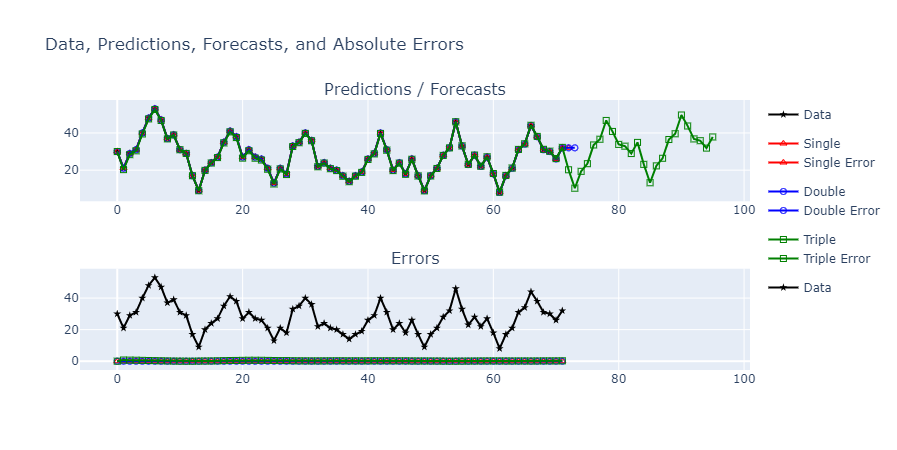

In [13]:
# plot the data & forecasts & error
fig = plysub.make_subplots(rows=2, cols=1, print_grid=False, subplot_titles=('Predictions / Forecasts', 'Errors'))
fig['layout'].update(title='Data, Predictions, Forecasts, and Absolute Errors', height=800)
# forecasts + data
fig.append_trace(go.Scatter(x=results.index, y=results['Data'], mode='markers+lines', name='Data',
                            marker={'color':'black', 'symbol':'star'}, line={'color':'black'}), 1, 1)
fig.append_trace(go.Scatter(x=results.index, y=results['ES_Sing'], mode='markers+lines', name='Single',
                            marker={'color':'red', 'symbol':'triangle-up-open'}, line={'color':'red'},
                            legendgroup='Single'), 1, 1)
fig.append_trace(go.Scatter(x=results.index, y=results['ES_Doub'], mode='markers+lines', name='Double',
                            marker={'color':'blue', 'symbol':'circle-open'}, line={'color':'blue'},
                            legendgroup='Double'), 1, 1)
fig.append_trace(go.Scatter(x=results.index, y=results['ES_Trip'], mode='markers+lines', name='Triple',
                  marker={'color':'green', 'symbol':'square-open'}, line={'color':'green'},
                            legendgroup='Triple'), 1, 1)
# errors + data
fig.append_trace(go.Scatter(x=results.index, y=results['Data'], mode='markers+lines', name='Data',
                            marker={'color':'black', 'symbol':'star'}, line={'color':'black'},
                            showlegend=True), 2, 1)
fig.append_trace(go.Scatter(x=results.index, y=results['ESErr_Sing'].abs(), mode='markers+lines', legendgroup='Single',
                            marker={'color':'red', 'symbol':'triangle-up-open'}, line={'color':'red'},
                            name='Single Error'), 2, 1)
fig.append_trace(go.Scatter(x=results.index, y=results['ESErr_Doub'].abs(), mode='markers+lines', legendgroup='Double',
                            marker={'color':'blue', 'symbol':'circle-open'}, line={'color':'blue'},
                            name='Double Error'), 2, 1)
fig.append_trace(go.Scatter(x=results.index, y=results['ESErr_Trip'].abs(), mode='markers+lines', legendgroup='Triple',
                            marker={'color':'green', 'symbol':'square-open'}, line={'color':'green'},
                            name='Triple Error'), 2, 1)

plyoff.iplot(fig)